In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from datetime import datetime
import talib
import pandas_ta as ta
from talib.abstract import *
from math import *
import pandas_ta as ta
import vectorbt as vbt

%matplotlib inline

In [8]:
df = pd.read_json(r'../freq-user-data/data/binance/BTC_USDT-1m.json')
df.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']

df['time'] = pd.to_datetime(df['timestamp'], unit='ms', utc=False)
# df.index = df['time']
# df.set_index('time', drop=True, inplace=True)
df.set_index(pd.DatetimeIndex(df["time"]), inplace=True, drop=True)
# df = df[['time', 'symbol', 'source', 'resolution', 'open', 'high', 'low', 'close', 'volume']]
# df.to_csv (r'./data/binance/BTC_USDT-5m.csv', index = None)
# df.set_index('time')


In [10]:
# pd.Timestamp('now').floor('D') + pd.Timedelta(-7, unit='D')

# start_time = pd.Timestamp('now').floor('D') + pd.Timedelta(-7, unit='D')

start_time = pd.Timestamp('now') + pd.Timedelta(-3, unit='W')
# start_time
ddf = df.loc[df.index >= start_time].copy()
# ddf = df.loc[df['time'] >= start_time]
len(ddf)

27278

In [119]:
# wdf = ddf.iloc[0:2 ** 10, :]
ddf['ema1'] = talib.EMA(ddf.close, 240)
ddf['ema1chg'] = talib.EMA( (ddf.close - ddf.ema1) / ddf.ema1 * 100 , 9)
ddf['chg'] = ddf.close  - ddf.close.vbt.fshift(1)
# ema = talib.EMA(ddf.ema1chg, 7)

In [100]:
ddf.ema1chg

time
2021-06-09 03:13:00         NaN
2021-06-09 03:14:00         NaN
2021-06-09 03:15:00         NaN
2021-06-09 03:16:00         NaN
2021-06-09 03:17:00         NaN
                         ...   
2021-06-28 01:46:00   -0.001359
2021-06-28 01:47:00   -0.001435
2021-06-28 01:48:00   -0.000936
2021-06-28 01:49:00   -0.001528
2021-06-28 01:50:00   -0.000845
Name: ema1chg, Length: 27278, dtype: float64

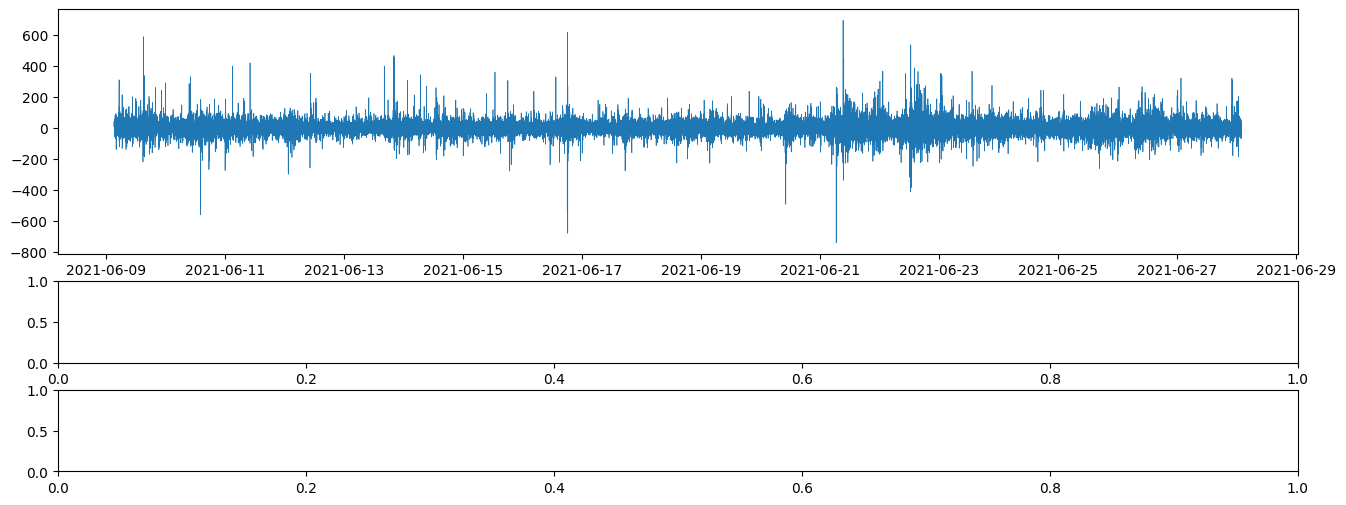

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(16,6), gridspec_kw={'height_ratios': [3,1,1]})
    
ax1.plot(ddf['chg'], lw=0.5)
# ax1.plot(ema, lw=0.5)



In [126]:
len(wdf)

1024

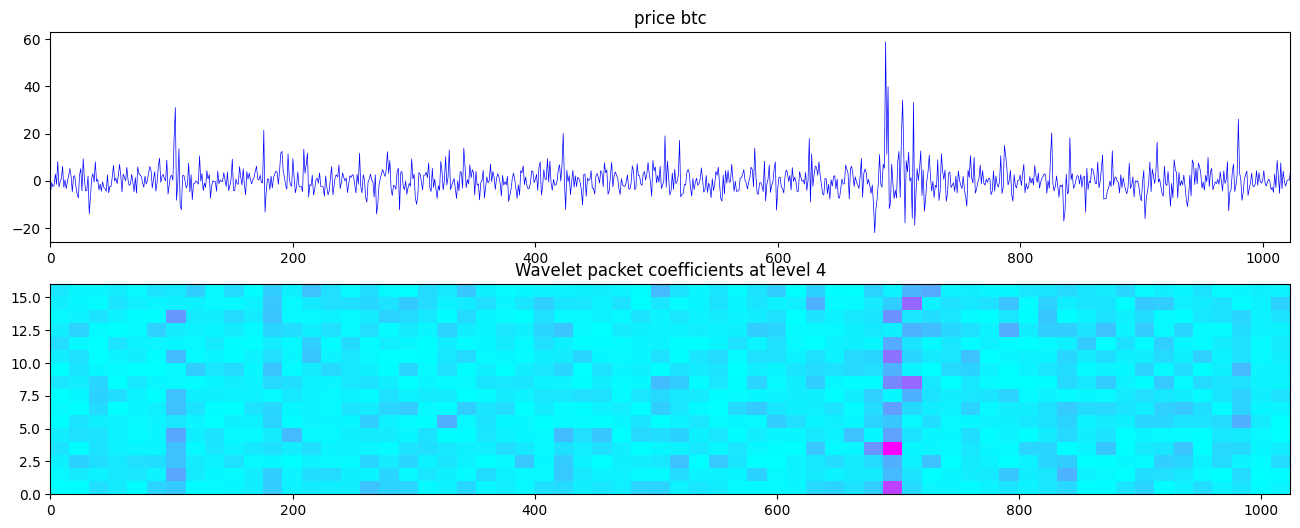

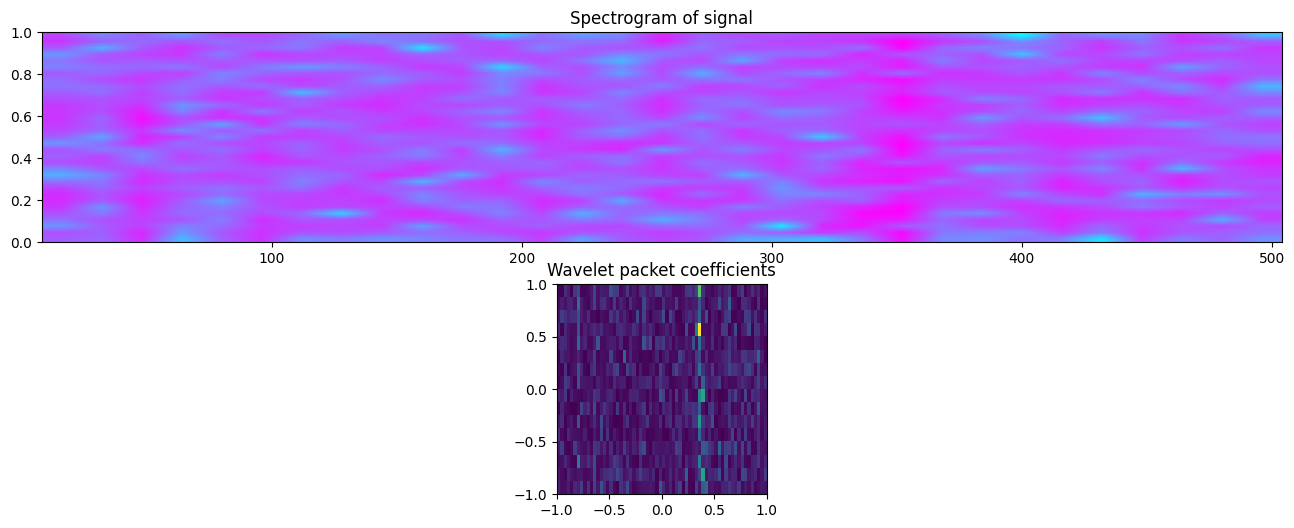

In [190]:
wdf = ddf.chg.iloc[20:(20 + 2 ** 10)] 

import numpy as np
import matplotlib.pyplot as plt

import pywt


# x = np.linspace(0, 1, num=512)
# data = np.sin(250 * np.pi * x**1.7)
# x = np.linspace(0, 1, len(wdf))
x = np.arange(0,len(wdf))
data = wdf / 10 #/50000

wavelet = 'haar'
level = 4
order = "natural" # "freq"  # other option is "normal"
interpolation = 'nearest'
cmap = plt.cm.cool

# Construct wavelet packet
wp = pywt.WaveletPacket(data, wavelet, 'smooth', maxlevel=level)
nodes = wp.get_level(level, order=order)
labels = [n.path for n in nodes]
values = np.array([n.data for n in nodes], 'd')
values = abs(values)

# # Show signal and wavelet packet coefficients
fig = plt.figure(figsize=(16,6))
# fig.subplots_adjust(hspace=0.2, bottom=.03, left=.07, right=.97, top=.92)
ax = fig.add_subplot(2, 1, 1)
ax.set_title("price btc")
ax.plot(x, data, 'b', lw=0.5)
ax.set_xlim(0, x[-1])

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Wavelet packet coefficients at level %d" % level)
ax.imshow(values, interpolation=interpolation, cmap=cmap, aspect="auto",
          origin="lower", extent=[0, len(wdf), 0, len(values)])
# ax.set_yticks(np.arange(0.5, len(labels) + 0.5), labels)

# # Show spectrogram and wavelet packet coefficients
fig2 = plt.figure(figsize=(16,6))
ax2 = fig2.add_subplot(211)
ax2.specgram(data, NFFT=64, noverlap=32, Fs=2, cmap=cmap,
             interpolation='bilinear')
ax2.set_title("Spectrogram of signal")

ax3 = fig2.add_subplot(212)
ax3.imshow(values, origin='upper', extent=[-1, 1, -1, 1],
           interpolation='nearest')
ax3.set_title("Wavelet packet coefficients")


plt.show()

In [153]:
wdf.index[1] - wdf.index[0]

Timedelta('0 days 00:01:00')

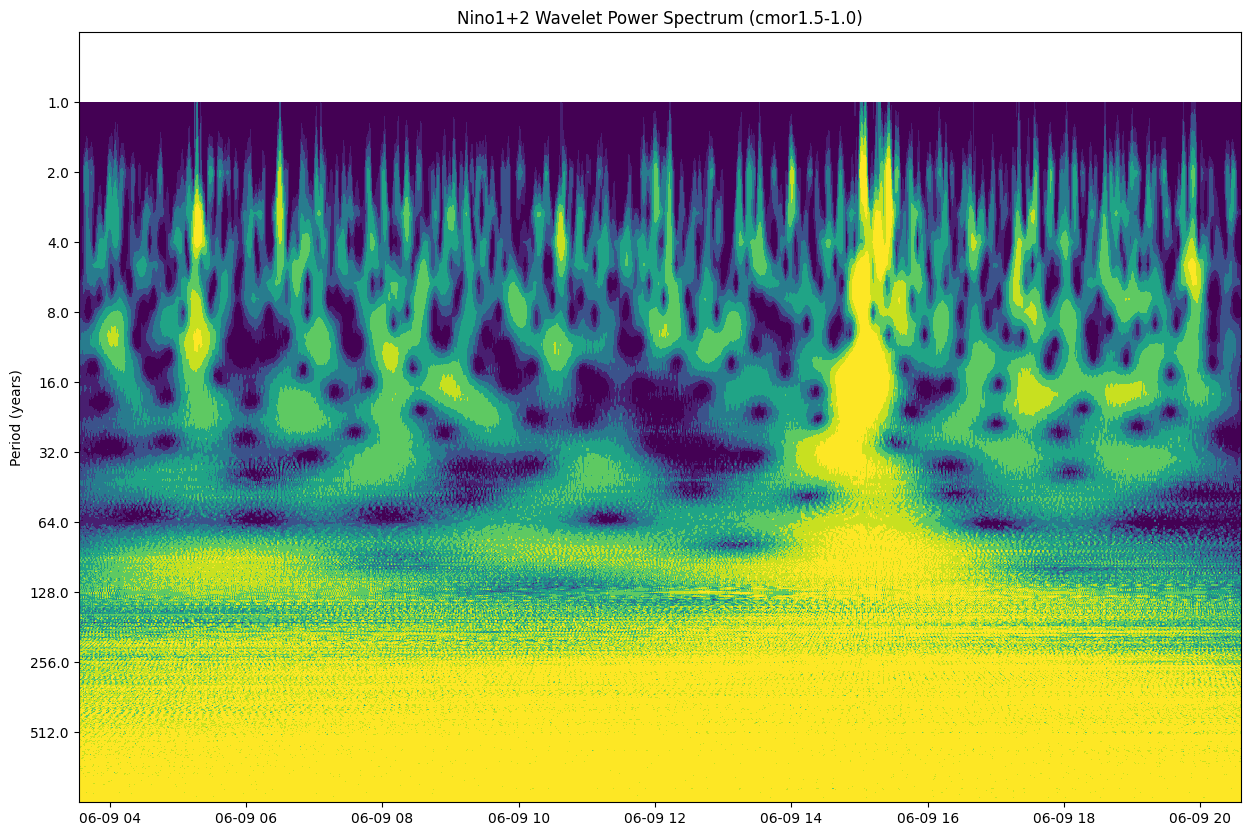

In [189]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt

import pywt


# time, sst = pywt.data.nino()
# dt = time[1] - time[0]

wdf = ddf.chg.iloc[20:(20 + 2 ** 10)] / 10
time = wdf.index
sst = wdf
dt = wdf.index[1] - wdf.index[0]



# Taken from http://nicolasfauchereau.github.io/climatecode/posts/wavelet-analysis-in-python/
wavelet = 'cmor1.5-1.0'
scales = np.arange(1, len(wdf))

[cfs, frequencies] = pywt.cwt(sst, scales, wavelet)
power = (abs(cfs)) ** 2

period = 1. / frequencies
# levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]

levels = [1, 2, 4, 8, 16, 32, 64]
f, ax = plt.subplots(figsize=(15, 10))
ax.contourf(time, np.log2(period), np.log2(power), np.log2(levels),
            extend='both')

ax.set_title('%s Wavelet Power Spectrum (%s)' % ('Nino1+2', wavelet))
ax.set_ylabel('Period (years)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                        np.ceil(np.log2(period.max())))
ax.set_yticks(np.log2(Yticks))
ax.set_yticklabels(Yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1)

plt.show()

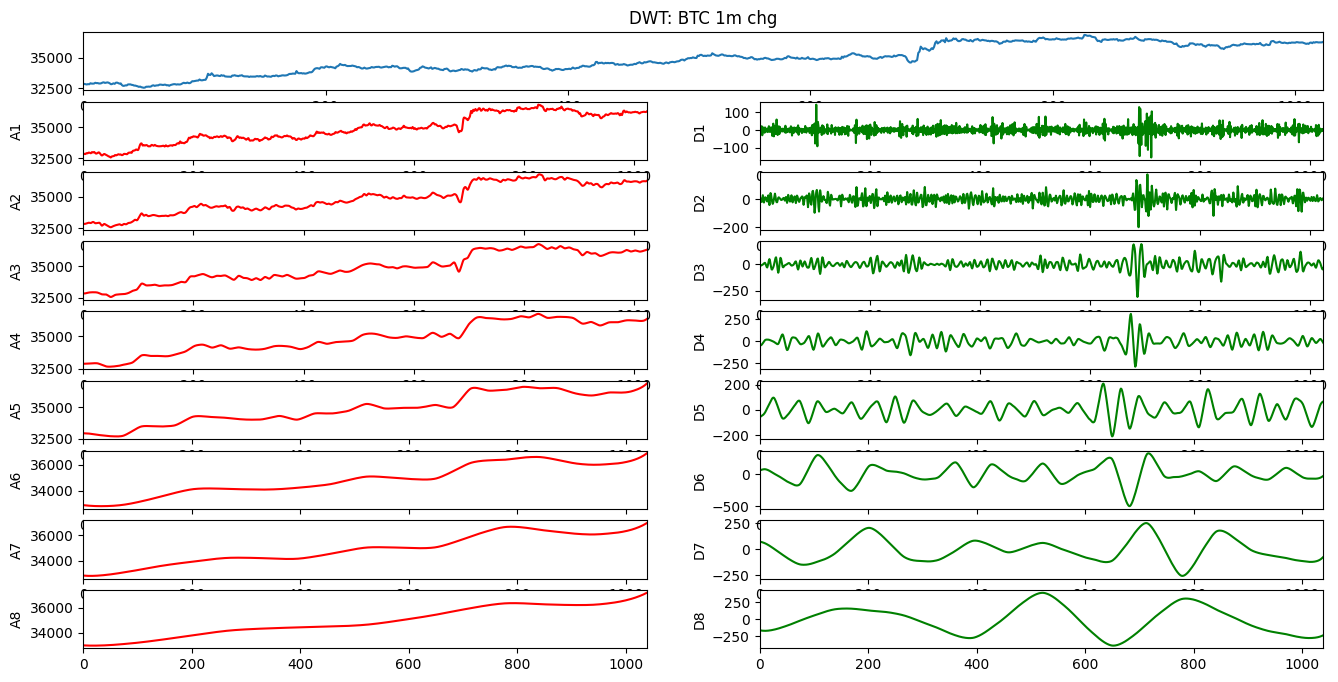

In [220]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data


ecg = pywt.data.ecg()

data1 = np.concatenate((np.arange(1, 400),
                        np.arange(398, 600),
                        np.arange(601, 1024)))
x = np.linspace(0.082, 2.128, num=1024)[::-1]
data2 = np.sin(40 * np.log(x)) * np.sign((np.log(x)))

mode = pywt.Modes.smooth


def plot_signal_decomp(data, w, title):
    """Decompose and plot a signal S.
    S = An + Dn + Dn-1 + ... + D1
    """
    w = pywt.Wavelet(w)
    a = data
    ca = []
    cd = []
    for i in range(8):
        (a, d) = pywt.dwt(a, w, mode)
        ca.append(a)
        cd.append(d)

    rec_a = []
    rec_d = []

    for i, coeff in enumerate(ca):
        coeff_list = [coeff, None] + [None] * i
        rec_a.append(pywt.waverec(coeff_list, w))

    for i, coeff in enumerate(cd):
        coeff_list = [None, coeff] + [None] * i
        rec_d.append(pywt.waverec(coeff_list, w))

    fig = plt.figure(figsize=(16,8))
    ax_main = fig.add_subplot(len(rec_a) + 1, 1, 1)
    ax_main.set_title(title)
    ax_main.plot(data)
    ax_main.set_xlim(0, len(data) - 1)

    for i, y in enumerate(rec_a):
        ax = fig.add_subplot(len(rec_a) + 1, 2, 3 + i * 2)
        ax.plot(y, 'r')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("A%d" % (i + 1))

    for i, y in enumerate(rec_d):
        ax = fig.add_subplot(len(rec_d) + 1, 2, 4 + i * 2)
        ax.plot(y, 'g')
        ax.set_xlim(0, len(y) - 1)
        ax.set_ylabel("D%d" % (i + 1))


wdf = ddf.close.iloc[20:(20 + 2 ** 10)].values 

plot_signal_decomp(wdf, 'coif3',
                   "DWT: BTC 1m chg")

# plot_signal_decomp(data1, 'coif5', "DWT: Signal irregularity")
# plot_signal_decomp(data2, 'sym5',
#                    "DWT: Frequency and phase change - Symmlets5")
# plot_signal_decomp(ecg, 'sym5', "DWT: Ecg sample - Symmlets5")


plt.show()

In [221]:
help(pywt.Modes)

Help on _Modes in module pywt._extensions._pywt object:

class _Modes(builtins.object)
 |  Because the most common and practical way of representing digital signals
 |  in computer science is with finite arrays of values, some extrapolation of
 |  the input data has to be performed in order to extend the signal before
 |  computing the :ref:`Discrete Wavelet Transform <ref-dwt>` using the
 |  cascading filter banks algorithm.
 |  
 |  Depending on the extrapolation method, significant artifacts at the
 |  signal's borders can be introduced during that process, which in turn may
 |  lead to inaccurate computations of the :ref:`DWT <ref-dwt>` at the signal's
 |  ends.
 |  
 |  PyWavelets provides several methods of signal extrapolation that can be
 |  used to minimize this negative effect:
 |  
 |  zero - zero-padding                   0  0 | x1 x2 ... xn | 0  0
 |  constant - constant-padding          x1 x1 | x1 x2 ... xn | xn xn
 |  symmetric - symmetric-padding        x2 x1 | x1 x2 ..